In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import make_data as md
import utils

In [ ]:
# Directly load combined and cleaned data. Otherwise run next section to create.
df = pd.read_csv('data/all_clean_data.csv')
df.info()

# Load, Clean, Combine, and Save Data

Do **NOT** run this section if data has been successfully read in with previous cell.

In [2]:
edf = md.combine_emotion_data()
edf = md.make_proxy_label(edf)
edf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19997 entries, 0 to 19996
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     19997 non-null  object
 1   emotion  19997 non-null  object
 2   label    19997 non-null  int32 
dtypes: int32(1), object(2)
memory usage: 390.7+ KB


In [3]:
edf = md.clean_data(edf)
edf.sample(n=3)

,emotion,label,processed_text
2551,joy,0,randomly talking found feeling cd listened qui...
7149,sadness,1,feel like missed singular flight took get z
8990,sadness,1,told felt better would go still feeling really...


In [5]:
df = pd.read_csv('data/Stress.csv')[['label', 'text']]
df = md.clean_data(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2838 entries, 0 to 2837
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   label           2838 non-null   int64 
 1   processed_text  2838 non-null   object
dtypes: int64(1), object(1)
memory usage: 44.5+ KB


In [6]:
edf = edf[['label', 'processed_text']].copy()
df = pd.concat([df, edf])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22835 entries, 0 to 19996
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   label           22835 non-null  int64 
 1   processed_text  22835 non-null  object
dtypes: int64(1), object(1)
memory usage: 535.2+ KB


In [7]:
df.duplicated().sum()

203

In [15]:
df = df.drop_duplicates(ignore_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22632 entries, 0 to 22631
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   label           22632 non-null  int64 
 1   processed_text  22632 non-null  object
dtypes: int64(1), object(1)
memory usage: 353.8+ KB


In [16]:
df.to_csv('data/all_clean_data.csv', index=False)

# Exploring the Dataset

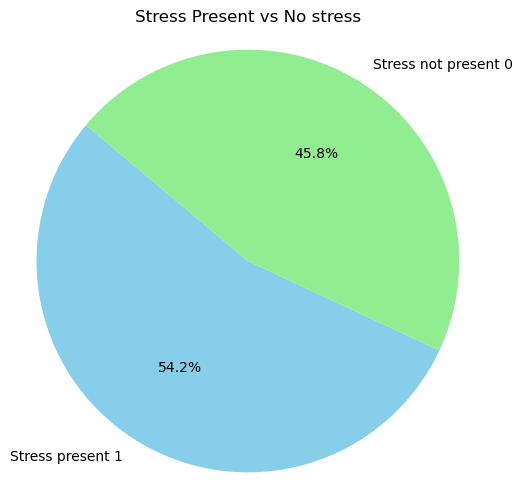

In [17]:
import matplotlib.pyplot as plt

# Sample binary dataset
labels = ['Stress present 1', 'Stress not present 0']
sizes=[sum(1 for label in df['label'] if label == 1),sum(1 for label in df['label'] if label == 0)]

# Create a pie chart
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'lightgreen'])

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')
plt.title('Stress Present vs No stress')
plt.show()

# Modeling Imports

In [19]:
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.layers import Dense, ReLU
from tensorflow.keras.layers import Embedding, BatchNormalization, Concatenate
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

2024-04-03 17:58:17.166439: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-03 17:58:17.166875: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-03 17:58:17.171033: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-03 17:58:17.225418: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-03 17:58:18.310715: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warnin

In [20]:
RANDOM_VALUE = 42
VOCAB_SIZE = 10_000

In [21]:
X_train, X_temp, y_train, y_temp = train_test_split(
    df['processed_text'], df['label'],
    test_size=0.3, random_state=RANDOM_VALUE
)
X_train.shape, y_train.shape

((15842,), (15842,))

In [22]:
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5, random_state=RANDOM_VALUE
)
X_val.shape, y_val.shape, X_test.shape, y_test.shape

((3395,), (3395,), (3395,), (3395,))

# ML with TF-IDF Embedding

# CNN

# LSTM

# GRU